# LIME example Iris dataset.

For this example we employ the Iris dataset that provides four attributes that can be used to classify flowers into three classes. 

Using this dataset we fit a Decision Tree as our original ML model, we then generate a number of random instances with the four attributes and use the Decision Tree to classify them. We then use LIME to fit a regression model that identifies which of the four attributes have the greatest impact in the model's classifications.

If we compare the structure of the decision tree to the output from LIME we can appreciate that they yield similar results. LIME concludes that only two of the four attributes play a significant role in the tree's decisions, petal width and length, and from the structure of the tree we can confirm that that is the case.

In [1]:
import sys
sys.path.insert(0, '../LIMEaid/controller')
sys.path.insert(0, '../LIMEaid/view')

In [2]:
import graphviz
import LIMEaid as la
import LIMEdisplay as ld
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn import tree

# Reading the contents of the iris dataset for testing purposes.
data_set = datasets.load_iris()
np.set_printoptions(threshold=np.inf)

# Number of perturbed samples to be generated.
n = 100000
# Number of bins for the histograms of continous attributes.
num_bins = 25

## Machine Learning model that is to be interpreted.

Use the Iris dataset to fit a model, a Decision Tree, that we'll use later to classify the random samples we generate.

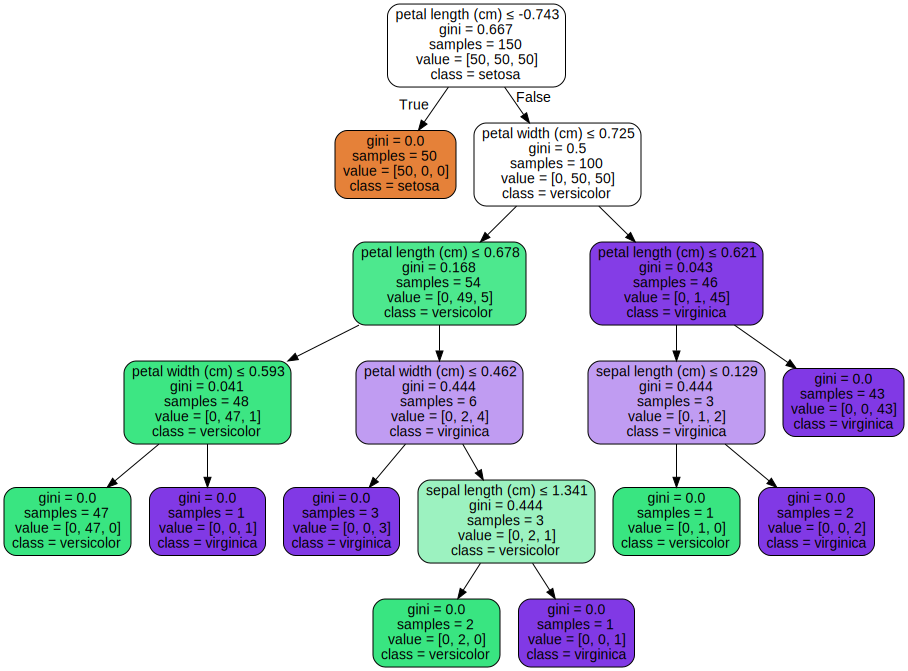

In [3]:
# Fitting a decision tree model to the iris dataset.
data_norm = preprocessing.scale(data_set.data)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_norm, data_set.target)
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data_set.feature_names,
                                class_names=data_set.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)

# graph.render creates a PDF file with a diagram of the structure
# of the decision tree. This file is stored in the local directory.
# graph.render("iris")

# graph creates a diagram of the structure of a decision tree and
# displays it in the notebook.
graph

Note that most nodes in the decision tree will do their classification based on either petal length or petal width. Only 3 of the 150 samples are classified based on sepal length, and 3 based on sepal width.

## Interpreting the output of the Decision Tree using LIME.

We now take the 150 instances of the Iris dataset, attributes only, and form them we generate n random samples with similar distributions in the values of each attribute.

In [4]:
# Bucketizing each attribute from the Iris dataset and
# generating perturbed samples with the same distribution.
perturbed_samples = np.zeros(n)
for j in range(0, data_set.data.shape[1]):
    array = data_set.data[:, j]
    output = la.lime_sample(n, True, array, num_bins)
    perturbed_samples = np.vstack((perturbed_samples, output))
perturbed_samples = np.transpose(perturbed_samples[1:, ])

Once random samples with the right distributions for each attribute have been generated, we provide them as input to the Decision Tree we fitted earlier, and obtain the classification for each.

In [5]:
class_perturb_samples = clf.predict(perturbed_samples)

We select a single instance from the Iris dataset. This is the instance we will try to interpret using LIME.

In [6]:
# Selecting the instance to interpret.
inst_num = np.round(np.random.uniform(0, data_set.data.shape[0], 1))
inst_num = inst_num[0].astype(int)
# x is the selected instance, and x_class is the class assigned
# by the decision tree. 
x = data_norm[inst_num, :]
x_class = data_set.target[inst_num]

## Calling LIME function to get intepretation.

In [7]:
# We now fit the LIME linear model to get the coefficients and
# intercept, as well as the weight of each random sample, 
# based on its L2 distance to the instance that is being
# interpreted.
lime_beta, lime_int, lime_weigh = la.lime_fit(x,
                                              x_class,
                                              perturbed_samples,
                                              class_perturb_samples)

# Print output of LIME results.
print("Instance to be interpreted:")
for j in range(0, len(lime_beta)):
    print("Feature: ", data_set.feature_names[j], "\tvalue: ",
          data_set.data[inst_num, j], "\tnormalized value: ",
          data_norm[inst_num, j])
print("Classification: ",
      data_set.target_names[data_set.target[inst_num]],
      data_set.target[inst_num])
print("\nSignificant coefficients from LIME adjusted"
      " linear model:")
for j in range(0, len(lime_beta)):
    if(lime_beta[j] != 0):
        print("Feature: ", data_set.feature_names[j],
              "\tCoefficient: ", lime_beta[j])
print("Intercept: ", lime_int)

Instance to be interpreted:
Feature:  sepal length (cm) 	value:  6.3 	normalized value:  0.5533332750260058
Feature:  sepal width (cm) 	value:  3.3 	normalized value:  0.5586108194543131
Feature:  petal length (cm) 	value:  4.7 	normalized value:  0.5354085615261401
Feature:  petal width (cm) 	value:  1.6 	normalized value:  0.5274062850564712
Classification:  versicolor 1

Significant coefficients from LIME adjusted linear model:
Feature:  petal length (cm) 	Coefficient:  0.23963698372623785
Feature:  petal width (cm) 	Coefficient:  0.6603354478669476
Intercept:  0.8278987201793908


## Intepreting the results

We selected the Decision Tree for this example because it provides an output that is interpretable: the structure of the tree itself. An examination of this structure reveals that, in almost all cases, branching decisions are made based on either petal length or petal width, which is what our LIME linear model is indicating as the LIME coefficients for sepal length and sepal width are zero.

Below we plot the random samples and the instance that is being interpreted on the petal length vs. petal width plane and, as we can observe, classes can be separated for the most part by looking at these two attributes. Note that those random samples that were classified differently from the instance we are interpreting are merged into a single out-of-class representation.

Finally, we separate all instances by how they were classified by the Decison Tree and compute the value of the LIME regression for each instance, as well as that of the instance we are explaining and plot the results.

We can see that the output of our LIME regression model separates all three classes for the most part.

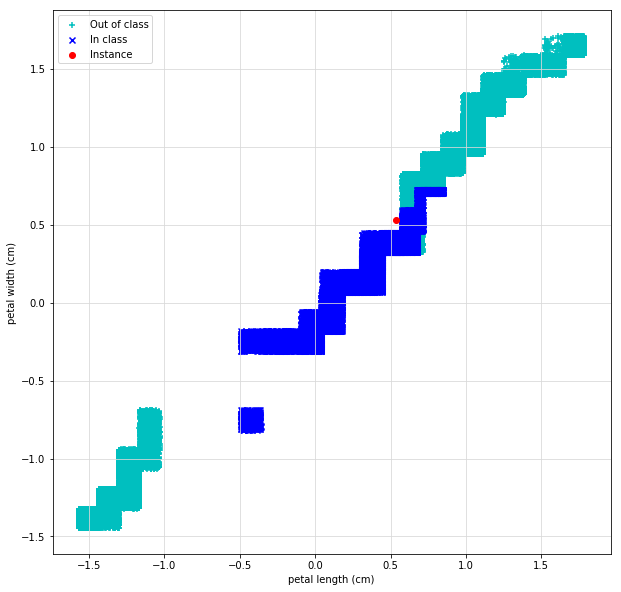

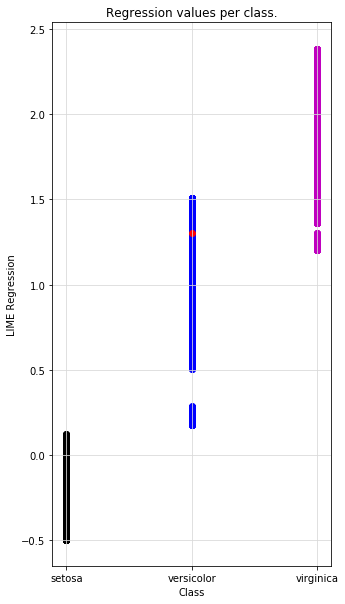

In [8]:
full_data = np.column_stack((perturbed_samples, class_perturb_samples))
ld.lime_display(full_data, lime_beta, lime_int, x, x_class, data_set.feature_names,
                data_set.target_names)